# Room Egress FP - Ahmed Abdelrahman

**Section-1 Two-dimensional Cellular Automaton Model**

***Python Implementation***

In [1]:
#Importing Libraries

import random
import time
import numpy as np
import pandas as pd
from copy import deepcopy
from random import shuffle
import scipy.stats as sts
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

The model below follows an algorithm that can be described as: 


1.   Place people and exits randomly in a two-dimensional grid, where exits are always on the edges of the room.
2.   Check and store the location of people and exits in the grid.
1.   Iterate through people's locations in the current state and update them synchronously. 
2.   If a person's location is the same as an exit location, then delete the person' locations from the grid in the next update (as they will leave the room). 

1.   If people are on the room sides, update their locations to move vertically to their nearest exit to them. If they are in the middle of the room, then move them horizontally to their nearest exits. When people see fixed objects (Walls) in the room, they turn around them and try to evacuate the room as fast as possible. 
2.   There is a stochastic parameter to capture the panicking behavior of people. If a person is panicked, they will not move for a one-time stamp. The following code illustrates the implementation of these rules. 

In [2]:
class crowd_egress:
    
    def __init__(self, room_w=10, room_h=10,people_num=25, exit_num=6,
                 exit_random=True ,exit_size=1, wall_size=0, wall_direction='v'
                 , panic_ratio=0.05):
        
        
        '''
        Create a new crowd egress object. People are distributed randomly
        in the room; exits can be randomly distributed or distributed with
        a pre-determined rule

        Inputs:

            room_w,room_h (int): The width and the hight of the room. 
            Default: 10
            
            people_num (int): The number of people in the room. Default:10
            
            exit_num (int): The number of exits in the room. Default: 6
            
            exit_random (boolean): The parameter controlling if doors will
             be randomly distributed in the room or not. Default: True

            exit_size (int): The size of each exit. Default: 1
            
            wall_size, wall_direction: The size of the wall and 
            the direction of it
            
            panic_ratio: a stochastic parameter to capture the panicking 
            behavior of people. If a person is panicked, they will not move. 
        '''
        
        self.room_w=room_w
        self.room_h=room_h
        self.people_num=people_num
        self.exit_num=exit_num
        self.exit_size=exit_size
        self.exit_random=exit_random
        self.wall_size=wall_size
        self.wall_direction=wall_direction
        self.panic_ratio=panic_ratio
        # A list with all exits' positions in the room 
        self.exit_coordinates=[]
        self.r_exit_coordinates=[] #for right edge exits
        self.l_exit_coordinates=[] #for left edge exits
        
        
        #Initializing an empty room with the given size
        self.current_state = scipy.zeros([self.room_h,self.room_w])
        #storingthe time steps and total number of people that left the room
        self.time = 0
        self.people_out=0
        #storing the location of people in the room
        self.wall_loc=[]
        
        
   
        
    def initialize(self):
        
        """Adding people, exits and walls to the room """
        
        
        #Adding a random wall to the room 
        #with a specified

        if self.wall_size!=0:
            if self.wall_direction=='v':
              #specifying random coloumn and row for the wall location
                col=random.randint(1,self.room_w-2)
                row=random.randint(1,self.room_h-self.wall_size-1)
                
        #the visualization of the room is reflected
        #where the [0] index of the object is the row number of it (y-axis)
                for i in range(self.wall_size):
                    self.wall_loc.append([row+i,col])
                    
            else:
                col=random.randint(1,self.room_w-self.wall_size-1)
                row=random.randint(1,self.room_h-2)

                for i in range(self.wall_size):
                    self.wall_loc.append([row,col+i])
            
            for loc in self.wall_loc:
                self.current_state[loc[0],loc[1]]=2
                    

        
        #Adding people to the room by specifying 
        #unique and random column/rows indexes 
        
        counter=0
        while counter < self.people_num:
            c_indx=random.randint(0,self.room_w-1)
            r_indx=random.randint(0,self.room_h-1)
            
            #checking that no position has more than 1 person
            if (self.current_state[r_indx,c_indx] !=1 and 
                self.current_state[r_indx,c_indx] !=2):
                self.current_state[r_indx,c_indx]=1
                counter+= 1    
                
        
    
        #if exit_random is true, we add random exits 
        #on the right or the left sides of the room 
        if self.exit_random:
            
            for _ in range(self.exit_num):
                
                placed= False
                #looping to ensure placing the right number 
                #of unique exits in the room
                while placed==False:
                    
                    edge = random.choice([0,self.room_w-1])
                    exit_proposed=[]
                    exit_start= random.randint(0,self.room_h-1)
                    edge_end= [*range(self.room_h-self.exit_size+1,
                                      self.room_h)]
                    
                    #Adding proposed exits to a list and ensuring
                    #that exits are placed with the right size
                    
                    if exit_start in edge_end:
                        #Increasing the exit size based on the user input 
                        for i in range((self.exit_size)):    
                            exit_proposed.append([exit_start-i,edge])
                    else:
                        for i in range((self.exit_size)):    
                            exit_proposed.append([exit_start+i,edge])
                            
                    #checking if the proposed exits are already
                    #located in the room. If so, iterate and propose new ones
                    check= True
                    for _ in exit_proposed:
                        if _ in self.exit_coordinates:
                            check=False
                    
                    if check:
                        for i in exit_proposed:
                            self.exit_coordinates.append(i)
                        placed=True
            
            #iterating through all exits and then
            #putting them in the right lists
            for exit in self.exit_coordinates:
                if exit[1]== 0:
                    self.l_exit_coordinates.append(exit)
                if exit[1]== self.room_h-1:
                    self.r_exit_coordinates.append(exit)
                
            
        #Placing exits with pre-determined rules
        #by optimizing the distances between exits
        
        else: 
            left_exit_num=self.exit_num//2
            right_exit_num=self.exit_num-left_exit_num

            for i in range(left_exit_num):
                for s in range(self.exit_size):
                    #placing exits based on this rule below
                    self.exit_coordinates.append(
                        [(i*((self.room_h//left_exit_num))+s),0])
                    self.l_exit_coordinates.append(
                        [(i*((self.room_h//left_exit_num))+s),0])

            for i in range(right_exit_num):
                for s in range(self.exit_size):
                    self.exit_coordinates.append(
                        [(i*((self.room_h//right_exit_num))+s),self.room_w-1])
                    self.r_exit_coordinates.append(
                        [(i*((self.room_h//right_exit_num))+s),self.room_w-1])
                
        

        
        
    def draw(self):
        """Plotting the current state of the simulation"""
        
        plt.cla()
        plt.pcolor(self.current_state, cmap="Blues")
        plt.axis('image')
        plt.title('t = ' + str(self.time))
    
    
    
    
                
    
    def update(self):
        
        """
        Updating the simulation synchronously by reading 
        from the current state and updating the next one. 
        The function egresses people in front of the exits
        and move people to the nearst exit to them
        
        """
        
        #Initializing an empty next_state
        self.next_state = scipy.zeros([self.room_h,self.room_w])
        #Adding walls to the room if any
        if self.wall_size != 0:
            for loc in self.wall_loc:
                    self.next_state[loc[0],loc[1]]=2

        #Locating each person in the room, so we can update their 
        #positions accordingly 
        people= np.where(np.array(self.current_state)==1)
        self.people_loc=[]
        for i in range(len(people[0])):
            self.people_loc.append([people[0][i],people[1][i]])
        
        
        #Egress people in front of exits
        
        people_out=[]
        for person in self.people_loc:
            if person in self.exit_coordinates:
                self.current_state[person[0],person[1]]=0
                people_out.append([person[0],person[1]])
                # A metric to calculate how many people have left the room
                # the metric is used to validate the simulation success
                self.people_out+=1
                
        #Removing people who left the room  from people's locations list
        for i in people_out:
            self.people_loc.remove(i)
        
        
        #iterating through people list
        #to update their location based on the simulation rules
        
        for person in self.people_loc:
            
            #Updating all people locations at the same time
            #through two functions. if the person is on the edges
            #upadte_edge will be activated, otherwide update
            #center will do the work 
            
            self.update_edges(person)
            self.update_center(person)
            
        #Updating the current_state synchronously
        self.current_state, self.next_state = self.next_state,self.current_state
        self.time +=1
        
        
 


    def update_edges(self, person):

    #if the person is on the left vertical edge
    #calculate the shortest path to the exit and 
    #follow it (vertical movement)

        if person[1]==0:

            if len(self.l_exit_coordinates)>=1:
                v_differences=[]
                move_direction=[]

                for exit in self.l_exit_coordinates:
                    v_differences.append(abs(exit[0]-person[0]))
                    if (exit[0]-person[0])>0:
                        move_direction.append(1)
                    else:
                        move_direction.append(-1)

                #shortest move
                move=move_direction[v_differences.index(min(v_differences))]

                #if we have two moves with the same 
                #distance, we pick randomly between them
                if (v_differences.count(min(v_differences))>1 
                    and (random.random()<=0.5)):
                    move=-(move)

                #update the next_state    
                if self.current_state[person[0]+move,person[1]]==1:
                    self.next_state[person[0],person[1]]=1
                else:
                    self.next_state[person[0]+move,person[1]]=1
                    self.current_state[person[0]+move,person[1]]=1
                    #self.current_state[person[0],person[1]]=0
            else:

                #update the next_state
                move=1
                if self.current_state[person[0],person[1]+move]==1:
                    self.next_state[person[0],person[1]]=1
                else:
                    self.next_state[person[0],person[1]+move]=1
                    self.current_state[person[0],person[1]+move]=1

    #if the person is on the right vertical edge
    #calculate the shortest path to the exit and 
    #follow it(vertical movement)

        if person[1]==self.room_w-1:

            if len(self.r_exit_coordinates)>=1:

                v_differences=[]
                move_direction=[]

                for exit in self.r_exit_coordinates:
                    v_differences.append(abs(exit[0]-person[0]))
                    if (exit[0]-person[0])>0:
                        move_direction.append(1)
                    else:
                        move_direction.append(-1)

                move=move_direction[v_differences.index(min(v_differences))]

                #if we have two moves with the same 
                #distance, we pick randomly between them
                if (v_differences.count(min(v_differences))>1
                    and (random.random()<=0.5)):
                    move=-move

                #update the next_state    
                if self.current_state[person[0]+move,person[1]]==1:
                    self.next_state[person[0],person[1]]=1
                else:
                    self.next_state[person[0]+move,person[1]]=1
                    self.current_state[person[0]+move,person[1]]=1
                    #self.current_state[person[0],person[1]]=0
            else:

                #update the next_state
                move=-1
                if self.current_state[person[0],person[1]+move]==1:
                    self.next_state[person[0],person[1]]=1
                else:
                    self.next_state[person[0],person[1]+move]=1
                    self.current_state[person[0],person[1]+move]=1

    
        
        
        
        
    def update_center(self,person):
                
            
    #if the person is not along the edges 
    #update their location to move to the nearst edge 
    #to them. (Horizontal Movements)
        if (person[1] != self.room_w-1) and (person[1] != 0):
            
            if self.panic_ratio >= random.random():
                #if a person is panicking, they will not move 
                #and update their position
                self.next_state[person[0],person[1]]=1
                
            else:
                
                if (len(self.l_exit_coordinates)>=1 
                    and len(self.r_exit_coordinates)>=1):


                    #checking the direction of the movement
                    move=0

                    if person[1]> (self.room_w-1)/2:
                        move=1
                    else:
                        move=-1

                    #moving people

                    if self.current_state[person[0],person[1]+move]==2:
                        #checking which vertical move to take (up or down)

                        if person[0]> (self.room_h-1)/2:
                            v_move=1
                        else:
                            v_move=-1

                        if self.current_state[person[0]+move,person[1]]==1:
                            self.next_state[person[0],person[1]]=1
                        else:
                            self.next_state[person[0]+move,person[1]]=1
                            self.current_state[person[0]+move,person[1]]=1

                    elif self.current_state[person[0],person[1]+move]==1:
                        self.next_state[person[0],person[1]]=1
                    else:
                        self.next_state[person[0],person[1]+move]=1
                        self.current_state[person[0],person[1]+move]=1

                else:

                  #Calculating the horizontal distance between people and exits

                    h_differences=[]
                    move_direction=[]

                    for exit in self.exit_coordinates:
                        h_differences.append(abs(exit[1]-person[1]))
                        if (exit[1]-person[1])>0:
                            move_direction.append(1)
                        else:
                            move_direction.append(-1)

                    #shortest move
                    move=move_direction[h_differences.index(min(h_differences))]

                    #if we have two moves with the same 
                    #distance, we pick randomly between them
                    if (h_differences.count(min(h_differences))>1 and
                        (random.random()<=0.5)):
                        move=-(move)

                    #update the next_state    
                    #moving people
                    if self.current_state[person[0],person[1]+move]==1:
                        self.next_state[person[0],person[1]]=1
                    else:
                        self.next_state[person[0],person[1]+move]=1
                        self.current_state[person[0],person[1]+move]=1

People Out: 0
People remaining in the Room: 25


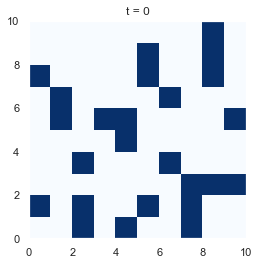

People out 1
People remaining in the Room 24


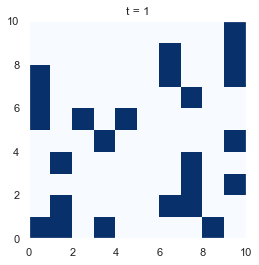

People out 6
People remaining in the Room 19


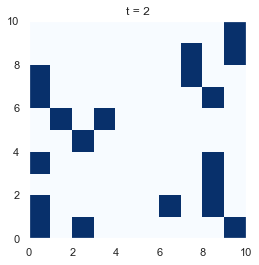

People out 9
People remaining in the Room 16


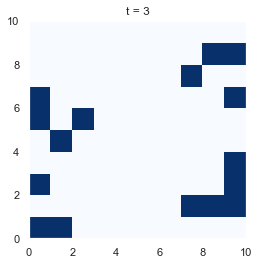

People out 13
People remaining in the Room 12


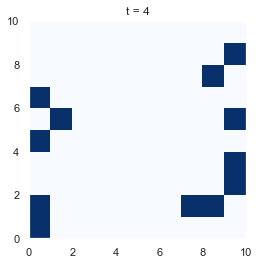

People out 17
People remaining in the Room 8


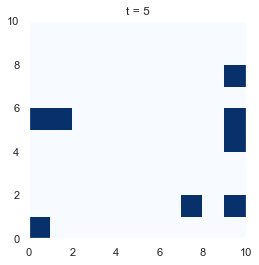

People out 19
People remaining in the Room 6


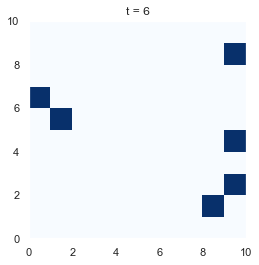

People out 23
People remaining in the Room 2


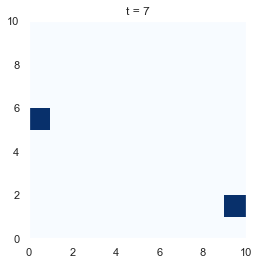

People out 23
People remaining in the Room 2


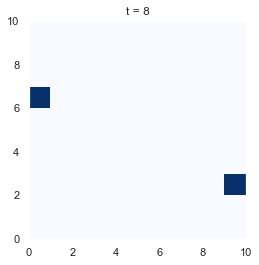

People out 25
People remaining in the Room 0


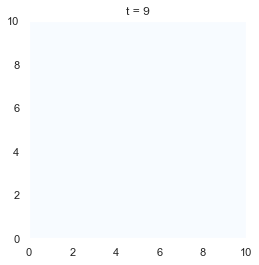

In [3]:
#Visualize and testing the state of the model over time
#With the default parameters

sim=crowd_egress(people_num=25,exit_num=6, room_h=10)
sim.initialize()

print("People Out:",sim.people_out)
print("People remaining in the Room:",
      np.count_nonzero(sim.current_state)-sim.wall_size)
sim.draw()
plt.show()

#A while loop to stop when the room is empty
while (np.count_nonzero(sim.current_state)-sim.wall_size) != 0:
    sim.update()
    
    #Two metrics to help debuging and
    #validating the simulation success
    print("People out",sim.people_out)
    print("People remaining in the Room",len(sim.people_loc))
    sim.draw()
    plt.show()

People Out 0
People In the Room 25


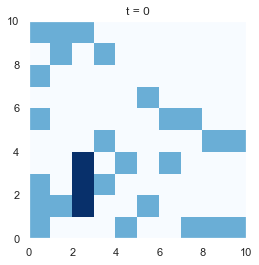

People out 2
People remaining 23


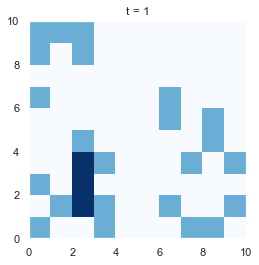

People out 5
People remaining 20


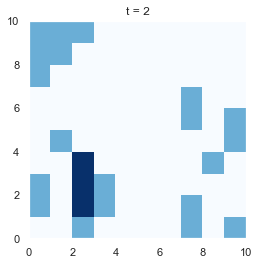

People out 6
People remaining 19


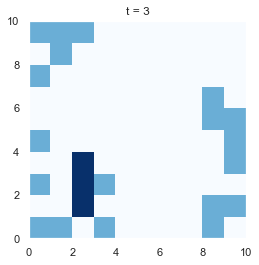

People out 10
People remaining 15


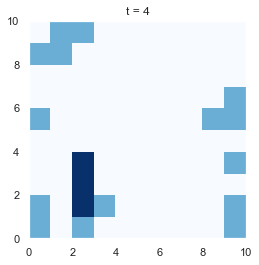

People out 13
People remaining 12


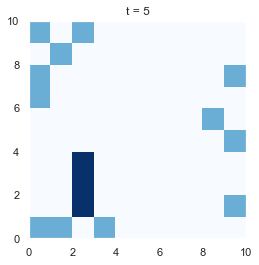

People out 17
People remaining 8


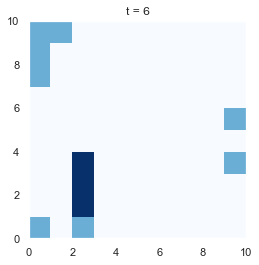

People out 20
People remaining 5


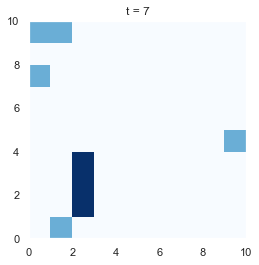

People out 21
People remaining 4


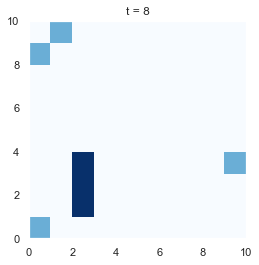

People out 23
People remaining 2


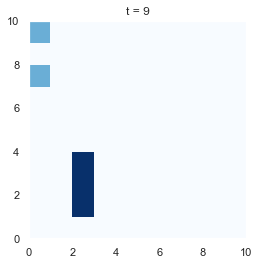

People out 24
People remaining 1


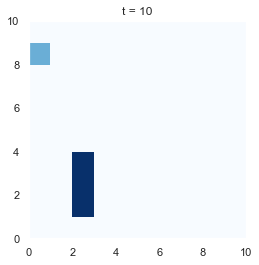

People out 24
People remaining 1


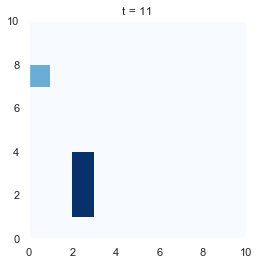

People out 25
People remaining 0


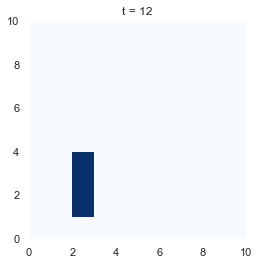

In [4]:
##Visualize and testing the state of the model over time
#By adding a vertical edge with with a size of 3

sim=crowd_egress(people_num=25,wall_size=3, wall_direction='v')
sim.initialize()

print("People Out",sim.people_out)
print("People In the Room",np.count_nonzero(sim.current_state)-sim.wall_size)
sim.draw()
plt.show()

#A while loop to stop when the room is empty
while (np.count_nonzero(sim.current_state)-sim.wall_size) != 0:
    sim.update()
    
    #Two metrics to help debuging and
    #validating the simulation success
    print("People out",sim.people_out)
    print("People remaining",len(sim.people_loc))
    sim.draw()
    plt.show()

In [5]:
#A function resposible for making animation 
#of the simulation 

def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """
    Write an animated GIF to file using matplotlib and ImageMagick.

    Inputs:

        draw_function (callable) The function to call, once per frame,
          to render to the current matplotlib figure. This function's call
          signature must be

            draw_function(current_frame_number, total_frame_count)

          The first frame is 0 and the last frame is total_frame_count-1.

        frames (int) The number of frames to generate.

        interval (float) The number of milliseconds to wait between frames
          in the animation. Set this to 40 for a fairly standard frame rate
          of 25fps (1 second / 40 (milliseconds per frame) = 25 frames per
          second).

        filename (str) The path to the file to write to. If none is provided,
          the animation will be written to a random filename, prefixed with
          "animate_" in the current directory. Default: None.

        verbose (bool) Whether to print the current frame number to the
          console as the animation is being created. This will clear other
          console output. Default: False.

        figure_params (dict) The keyword arguments to pass to matplotlib
          when creating a new figure for this animation. Use it to set the
          figure size and other figure properties. Default: None.

    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    from matplotlib import pyplot, animation
    from IPython.display import HTML, display, clear_output
    import random

    if filename is None:
        filename = 'animate_%06i.gif' % random.randint(0, 999999)
    # Create figure
    if figure_params is None:
        figure_params = {}
    figure = pyplot.figure(**figure_params)
    # Wrap draw_function if we need to print to console
    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', 
                  total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)
    # Generate animation
    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    anim.save(filename, writer='imagemagick')
    # Close the animation figure so the last frame does not get displayed
    # in the notebook.
    pyplot.close()
    # Return display object for the animated GIF
    return display(HTML('<img src="' + filename + '">'))

In [6]:
#An animation of the simulation 
#for better visualization and results
sim=crowd_egress()
sim.initialize()

def animate_simulation(frame, total_frames):
    sim.update()
    sim.draw()


while (np.count_nonzero(sim.current_state)-sim.wall_size) != 0:
    make_animation(
        animate_simulation, frames=1, interval=1,
        figure_params={'figsize': (5, 4)},
        verbose=True)
    time.sleep(0.7)

***Part-2 Parameters Experiments***

In [7]:
"""
Experiment-1

Exit Number vs Evacuation Time 

A simulation experiment of different number of 
exits on Evacuation time
The number of exits are varied from 1 to 14 
with the fixed default parameters 

Each step is counted as one interval in this scenario. 

"""

exits_num= [*range(1,15)]
trails=1000

E1_steps = []
E1_median_time=[]
E1_mode_time=[]
E1_mean_time=[]

for num in exits_num:
    counts=[]
    for i in range(trails):
        sim =crowd_egress(exit_num=num)
        sim.initialize()
        while np.count_nonzero(sim.current_state) != 0:
            sim.update()
        counts.append(sim.time)    
        E1_steps.append([num,sim.time])
        
    E1_median_time.append(np.median(counts))
    E1_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E1_mode_time.append(max(set(counts), key=counts.count))

#E1_input = [_[0] for _ in E1_steps]
E1_time = [_[1] for _ in E1_steps]

95% Confidence Interval: (27.833986250083605, 29.831728035630682)
05th-95th percentiles of the data: (7.0, 167.0)
DescribeResult(nobs=14000, minmax=(5, 613), mean=28.832857142857144, variance=3635.5947486044915, skewness=4.533343223274561, kurtosis=22.228262368498626)


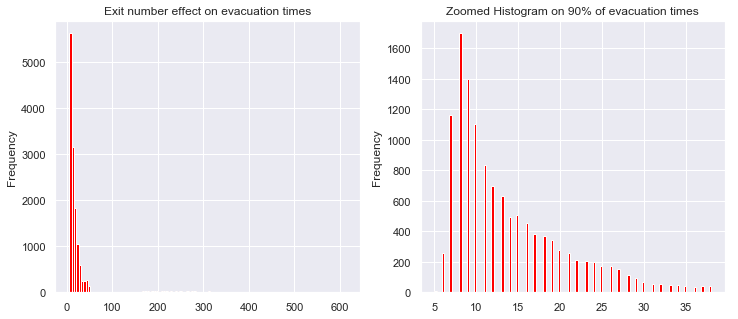

In [8]:
#Histogrm of the expriment times with
#their frequencies 


print ("95% Confidence Interval:", sts.t.interval(0.95, len(E1_time)-1,loc=np.mean(E1_time), scale=sts.sem(E1_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E1_time, 0.05),np.quantile(E1_time, 0.95)))
print(sts.describe(E1_time))


#Focusing on 90% of the data
E1_zoomed_times=[]
for i in E1_time:
    if (i<=np.quantile(E1_time, 0.90)):
        E1_zoomed_times.append(i)     
        
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.hist(E1_time,bins = int(np.sqrt(len(E1_time))), color = "red")
plt.title("Exit number effect on evacuation times")
plt.ylabel("Frequency")


plt.subplot(1, 2, 2)

plt.hist(E1_zoomed_times,bins = int(np.sqrt(len(E1_zoomed_times))), color = "red")
plt.title("Zoomed Histogram on 90% of evacuation times")
plt.ylabel("Frequency")

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

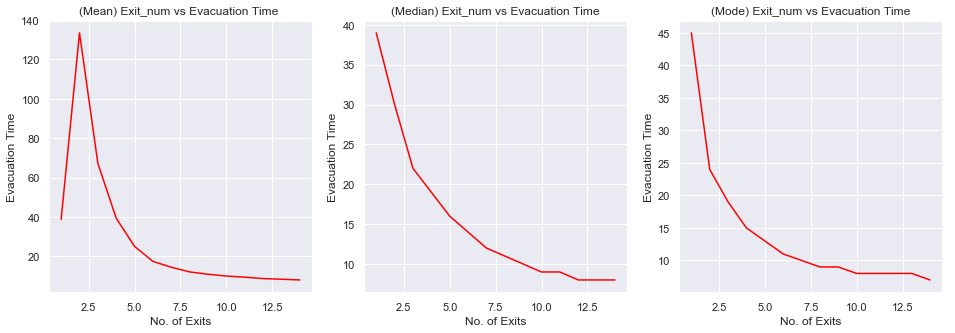

In [9]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)

plt.plot(exits_num,E1_mean_time, color = "red")
plt.title("(Mean) Exit_num vs Evacuation Time ")
plt.xlabel("No. of Exits")
plt.ylabel("Evacuation Time")



plt.subplot(1, 3, 2)

plt.plot(exits_num,E1_median_time, color = "red")
plt.title("(Median) Exit_num vs Evacuation Time")
plt.xlabel("No. of Exits")
plt.ylabel("Evacuation Time")

plt.subplot(1, 3, 3)

plt.plot(exits_num,E1_mode_time, color = "red")
plt.title("(Mode) Exit_num vs Evacuation Time")
plt.xlabel("No. of Exits")
plt.ylabel("Evacuation Time")

plt.show

In [10]:
"""
Experiment-2

Number of People vs Evacuation Time 

A simulation experiment of different numbers of people on 
Evacuation time
The number of people are varied from 1 to 28 
with the fixed default parameters 


Each step is counted as one interval in this scenario. 

"""

people_num= [*range(1,29)]
trails=500
E2_steps = []
E2_median_time=[]
E2_mode_time=[]
E2_mean_time=[]

for num in people_num:
    counts=[]
    for i in range(trails):
        sim =crowd_egress(people_num=num)
        sim.initialize()
        while np.count_nonzero(sim.current_state) != 0:
            sim.update()
        counts.append(sim.time)    
        E2_steps.append([num,sim.time])
        
    E2_median_time.append(np.median(counts))
    E2_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E2_mode_time.append(max(set(counts), key=counts.count))

#E2_input = [_[0] for _ in E2_steps]
E2_time = [_[1] for _ in E2_steps]

95% Confidence Interval: (12.359987096571222, 13.117727189143062)
05th-95th percentiles of the data: (5.0, 20.0)
DescribeResult(nobs=14000, minmax=(1, 557), mean=12.738857142857142, variance=523.0428788995133, skewness=12.553436133449555, kurtosis=185.65060304415334)


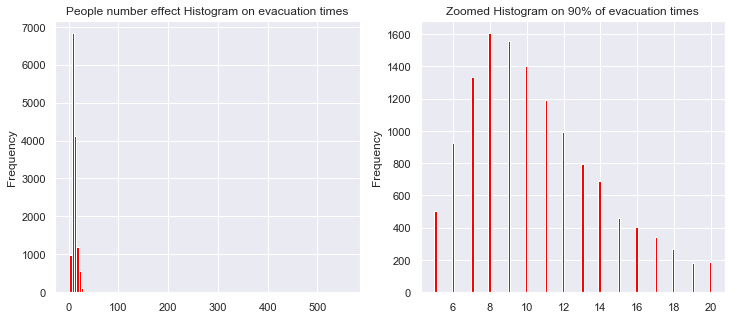

In [11]:
#Histogrm of the expriment times with
#their frequencies 


print ("95% Confidence Interval:", sts.t.interval(0.95, len(E2_time)-1, loc=np.mean(E2_time), scale=sts.sem(E2_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E2_time, 0.05),np.quantile(E2_time, 0.95)))
print(sts.describe(E2_time))


#Zooming on the 90% of the data
E2_zoomed_times=[]
for i in E2_time:
    if (i>=np.quantile(E2_time, 0.05)) and (i<=np.quantile(E2_time, 0.95)):
        E2_zoomed_times.append(i)     
        
        
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.hist(E2_time,bins = int(np.sqrt(len(E2_time))), color = "red")
plt.title("People number effect Histogram on evacuation times")
plt.ylabel("Frequency")


plt.subplot(1, 2, 2)

plt.hist(E2_zoomed_times,bins = int(np.sqrt(len(E2_zoomed_times))), color = "red")
plt.title("Zoomed Histogram on 90% of evacuation times")
plt.ylabel("Frequency")

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

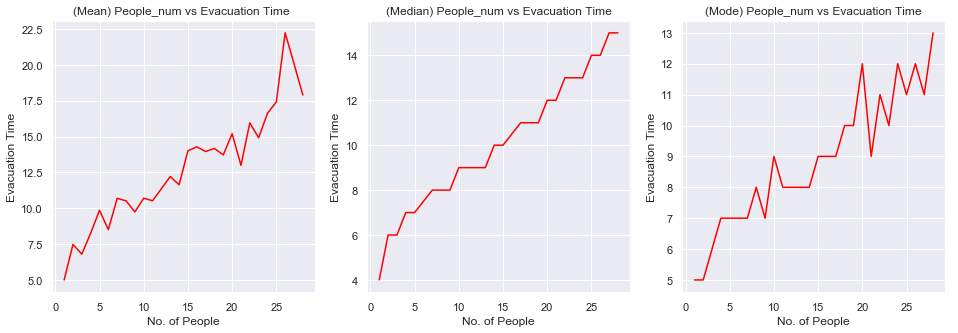

In [12]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)

plt.plot(people_num,E2_mean_time, color = "red")
plt.title("(Mean) People_num vs Evacuation Time ")
plt.xlabel("No. of People")
plt.ylabel("Evacuation Time")


plt.subplot(1, 3, 2)

plt.plot(people_num,E2_median_time, color = "red")
plt.title("(Median) People_num vs Evacuation Time")
plt.xlabel("No. of People")
plt.ylabel("Evacuation Time")

plt.subplot(1, 3, 3)

plt.plot(people_num,E2_mode_time, color = "red")
plt.title("(Mode) People_num vs Evacuation Time")
plt.xlabel("No. of People")
plt.ylabel("Evacuation Time")

plt.show

In [13]:
"""
Experiment-3

Exit Size vs Evacuation Time 

A simulation experiment of different Exit sizes
on Evacuation time
The Exit sizes are varied from 1 to 10
and of two Exits and the rest of 
the fixed default parameters 


"""

exit_size= [*range(1,11)]
trails=1400
E3_steps = []
E3_median_time=[]
E3_mode_time=[]
E3_mean_time=[]

for num in exit_size:
    counts=[]
    for i in range(trails):
        sim =crowd_egress(exit_num=2, exit_size=num, exit_random=False)
        sim.initialize()
        while np.count_nonzero(sim.current_state) != 0:
            sim.update()
        counts.append(sim.time)    
        E3_steps.append([num,sim.time])
        
    E3_median_time.append(np.median(counts))
    E3_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E3_mode_time.append(max(set(counts), key=counts.count))

#E3_input = [_[0] for _ in E3_steps]
E3_time = [_[1] for _ in E3_steps]

95% Confidence Interval: (15.722552351488108, 15.971733362797607)
05th-95th percentiles of the data: (6.0, 28.0)
DescribeResult(nobs=14000, minmax=(5, 38), mean=15.847142857142858, variance=56.56224628289775, skewness=0.32627367306894833, kurtosis=-1.0912165843992174)


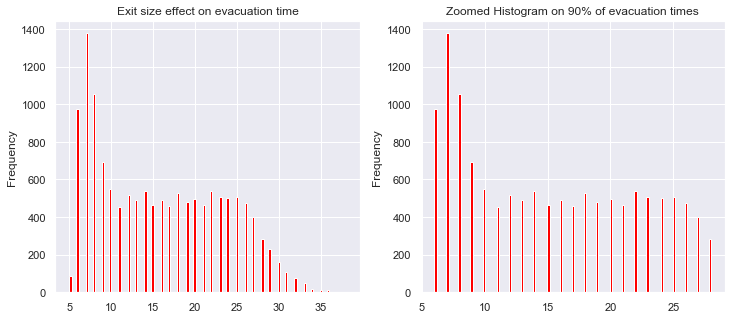

In [14]:
#Histogrm of the expriment times with
#their frequencies 


print ("95% Confidence Interval:", sts.t.interval(0.95, len(E3_time)-1, loc=np.mean(E3_time), scale=sts.sem(E3_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E3_time, 0.05),np.quantile(E3_time, 0.95)))
print(sts.describe(E3_time))


#finding the 90% percentile of the data
E3_zoomed_times=[]
for i in E3_time:
    if (i>=np.quantile(E3_time, 0.05)) and (i<=np.quantile(E3_time, 0.95)):
        E3_zoomed_times.append(i)     
        
        
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.hist(E3_time,bins = int(np.sqrt(len(E3_time))), color = "red")
plt.title("Exit size effect on evacuation time")
plt.ylabel("Frequency")


plt.subplot(1, 2, 2)

plt.hist(E3_zoomed_times,bins = int(np.sqrt(len(E3_zoomed_times))), color = "red")
plt.title("Zoomed Histogram on 90% of evacuation times")
plt.ylabel("Frequency")

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

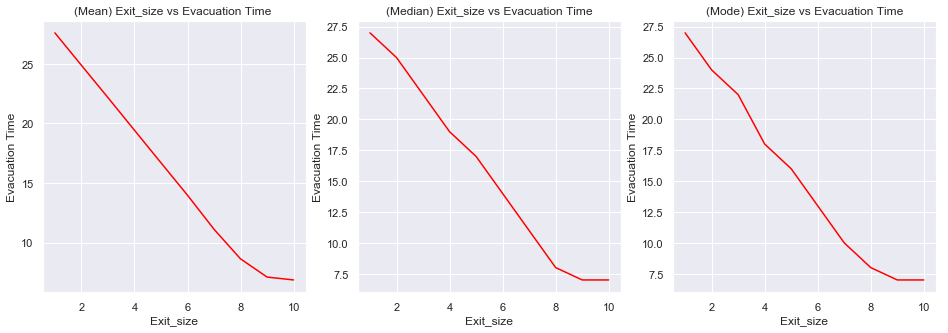

In [15]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)

plt.plot(exit_size,E3_mean_time, color = "red")
plt.title("(Mean) Exit_size vs Evacuation Time ")
plt.xlabel("Exit_size")
plt.ylabel("Evacuation Time")


plt.subplot(1, 3, 2)

plt.plot(exit_size,E3_median_time, color = "red")
plt.title("(Median) Exit_size vs Evacuation Time")
plt.xlabel("Exit_size")
plt.ylabel("Evacuation Time")

plt.subplot(1, 3, 3)

plt.plot(exit_size,E3_mode_time, color = "red")
plt.title("(Mode) Exit_size vs Evacuation Time")
plt.xlabel("Exit_size")
plt.ylabel("Evacuation Time")

plt.show

In [16]:
"""
Experiment-4

Room Size vs Evacuation Time 

A simulation experiment of different Room
dimensions on Evacuation time
The Room h and w are varied from 8 to 22
with the rest of fixed default parameters 

"""
room_size= [*range(8,22)]
trails=1000

E4_steps = []
E4_median_time=[]
E4_mode_time=[]
E4_mean_time=[]

for num in room_size:
    counts=[]
    for i in range(trails):
        sim =crowd_egress(room_h=num, room_w=num)
        sim.initialize()
        while np.count_nonzero(sim.current_state) != 0:
            sim.update()
        counts.append(sim.time)    
        E4_steps.append([num,sim.time])
        
    E4_median_time.append(np.median(counts))
    E4_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E4_mode_time.append(max(set(counts), key=counts.count))

#E4_input = [_[0] for _ in E4_steps]
E4_time = [_[1] for _ in E4_steps]

95% Confidence Interval: (26.237506012189062, 29.52120827352522)
05th-95th percentiles of the data: (10.0, 28.0)
DescribeResult(nobs=14000, minmax=(6, 2773), mean=27.879357142857142, variance=9822.551270391761, skewness=11.976010573397875, kurtosis=176.1314612707289)
Data mode: 16


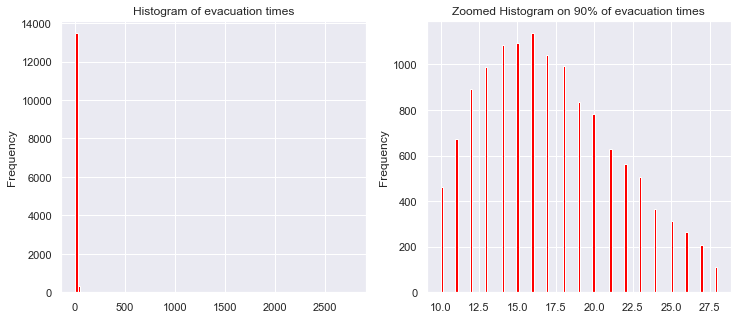

In [17]:
#Histogrm of the expriment times with
#their frequencies 


print ("95% Confidence Interval:", sts.t.interval(0.95, len(E4_time)-1, loc=np.mean(E4_time), scale=sts.sem(E4_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E4_time, 0.05),np.quantile(E4_time, 0.95)))
print(sts.describe(E4_time))
print("Data mode:",max(set(E4_time), key=E4_time.count))


#finding the 90% percentile of the data
E4_zoomed_times=[]
for i in E4_time:
    if (i>=np.quantile(E4_time, 0.05)) and (i<=np.quantile(E4_time, 0.95)):
        E4_zoomed_times.append(i)     
        
        
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.hist(E4_time,bins = int(np.sqrt(len(E4_time))), color = "red")
plt.title("Histogram of evacuation times")
plt.ylabel("Frequency")


plt.subplot(1, 2, 2)

plt.hist(E4_zoomed_times,bins = int(np.sqrt(len(E4_zoomed_times))), color = "red")
plt.title("Zoomed Histogram on 90% of evacuation times")
plt.ylabel("Frequency")

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

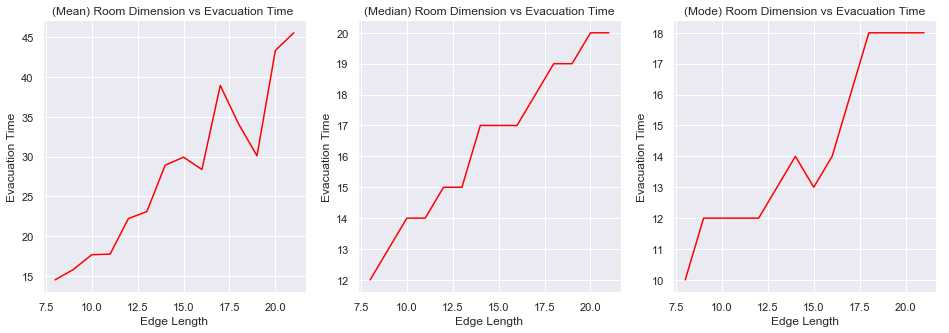

In [18]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)

plt.plot(room_size,E4_mean_time, color = "red")
plt.title("(Mean) Room Dimension vs Evacuation Time ")
plt.xlabel("Edge Length")
plt.ylabel("Evacuation Time")


plt.subplot(1, 3, 2)

plt.plot(room_size,E4_median_time, color = "red")
plt.title("(Median) Room Dimension vs Evacuation Time")
plt.xlabel("Edge Length")
plt.ylabel("Evacuation Time")

plt.subplot(1, 3, 3)

plt.plot(room_size,E4_mode_time, color = "red")
plt.title("(Mode) Room Dimension vs Evacuation Time")
plt.xlabel("Edge Length")
plt.ylabel("Evacuation Time")

plt.show

**Section-2 Comparing Exit Placement strategies**

***Part-1 Experiments***

In [19]:
"""
Experiment-5

strategic non-random exit placement
Exit Number vs Evacuation Time 

A simulation experiment of different number of exits on 
Evacuation time
The number of exits are varied from 1 to 11 
with the fixed default parameters 


Each step is counted as one interval in this scenario. 

"""

exits_num= [*range(1,11)]
trails=1000

E5_steps = []
E5_median_time=[]
E5_mode_time=[]
E5_mean_time=[]

for num in exits_num:
    counts=[]
    for i in range(trails):
        sim =crowd_egress(exit_num=num, exit_random=False)
        sim.initialize()
        while np.count_nonzero(sim.current_state) != 0:
            sim.update()
        counts.append(sim.time)    
        E5_steps.append([num,sim.time])
        
    E5_median_time.append(np.median(counts))
    E5_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E5_mode_time.append(max(set(counts), key=counts.count))

#E5_input = [_[0] for _ in E5_steps]
E5_time = [_[1] for _ in E5_steps]


#-------------------------------------------------
#randomly placing exits
E6_steps = []
E6_median_time=[]
E6_mode_time=[]
E6_mean_time=[]

for num in exits_num:
    counts=[]
    for i in range(trails):
        sim =crowd_egress(exit_num=num, exit_random=True)
        sim.initialize()
        while np.count_nonzero(sim.current_state) != 0:
            sim.update()
        counts.append(sim.time)    
        E6_steps.append([num,sim.time])
        
    E6_median_time.append(np.median(counts))
    E6_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E6_mode_time.append(max(set(counts), key=counts.count))

#E5_input = [_[0] for _ in E5_steps]
E6_time = [_[1] for _ in E6_steps]

95% CI of Strategic Placement: (18.007421798192176, 18.465578201807823)
05th-95th percentiles of the data: (8.0, 48.0)
DescribeResult(nobs=10000, minmax=(6, 55), mean=18.2365, variance=136.57342509250927, skewness=1.5011515927023742, kurtosis=1.3085798049454391)
--------------------------------
95% CI of Random Placement: (36.141534301111484, 38.92546569888851)
05th-95th percentiles of the data: (8.0, 227.0)
DescribeResult(nobs=10000, minmax=(5, 671), mean=37.5335, variance=5042.614139163915, skewness=3.666121473564117, kurtosis=13.90975444607616)


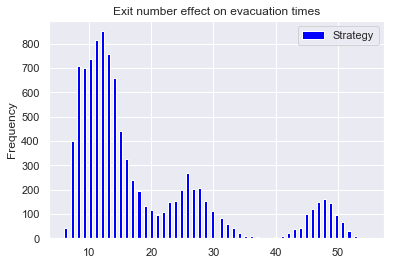

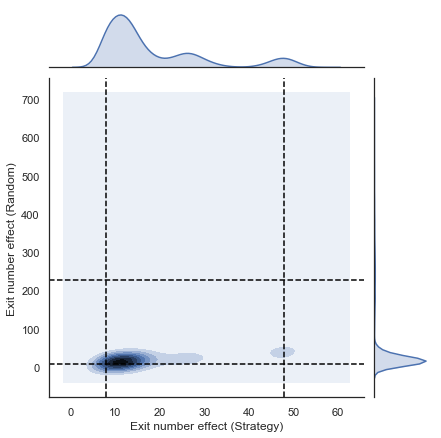

In [20]:
#Histogrm of the expriment times with
#their frequencies 

print ("95% CI of Strategic Placement:", sts.t.interval(0.95, len(E5_time)-1,
                                                                 loc=np.mean(E5_time), scale=sts.sem(E5_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E5_time, 0.05),np.quantile(E5_time, 0.95)))
print(sts.describe(E5_time))
print("--------------------------------")
print ("95% CI of Random Placement:", sts.t.interval(0.95, len(E6_time)-1, loc=np.mean(E6_time),
                                                         scale=sts.sem(E6_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E6_time, 0.05),np.quantile(E6_time, 0.95)))
print(sts.describe(E6_time))



# #finding the 90% percentile of the data

# E5_zoomed_times=[]
# for i in E5_time:
#     if (i<=np.quantile(E5_time, 0.90)):
#         E5_zoomed_times.append(i)     
        
        
# E6_zoomed_times=[]
# for i in E6_time:
#     if (i<=np.quantile(E6_time, 0.90)):
#         E6_zoomed_times.append(i) 
        
        

plt.hist(E5_time,bins = int(np.sqrt(len(E5_time))), color = "blue",label='Strategy')
#plt.hist(E6_time,bins = int(np.sqrt(len(E6_time))), color = "red",label='Random',alpha=0.65)
plt.title("Exit number effect on evacuation times")
plt.ylabel("Frequency")
plt.legend()



with sns.axes_style("white"):
    #sns.jointplot(x=E5_time, y=E6_time, kind="kde", ax=axes[0, 1]);
    fig = sns.jointplot(x=E5_time, y=E6_time, kind='kde', n_levels=10)
    fig.ax_joint.axvline(x=np.quantile(E5_time, 0.05), linestyle='--', color = 'black')
    fig.ax_joint.axvline(x=np.quantile(E5_time, 0.95), linestyle='--', color = 'black')
    fig.ax_joint.axhline(y=np.quantile(E6_time, 0.05), linestyle='--', color = 'black')
    fig.ax_joint.axhline(y=np.quantile(E6_time, 0.95), linestyle='--', color = 'black')
    fig.set_axis_labels('Exit number effect (Strategy)', 'Exit number effect (Random)')

plt.show()

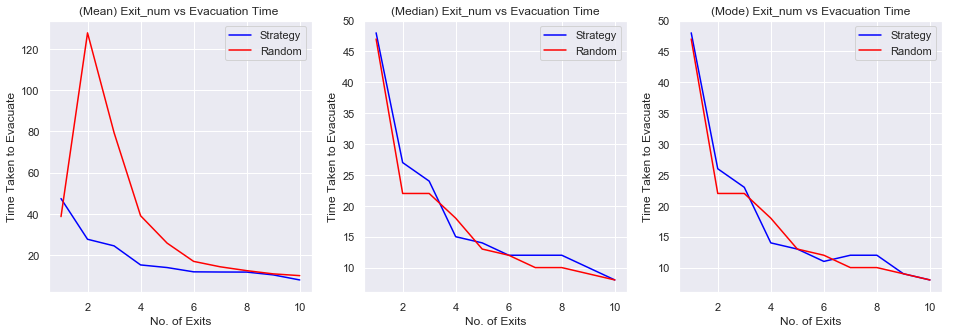

In [21]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)

plt.plot(exits_num,E5_mean_time, color = "blue",label='Strategy')
plt.plot(exits_num,E6_mean_time, color = "red",label='Random')

plt.title("(Mean) Exit_num vs Evacuation Time ")
plt.xlabel("No. of Exits")
plt.ylabel("Time Taken to Evacuate")
plt.legend()



plt.subplot(1, 3, 2)

plt.plot(exits_num,E5_median_time, color = "blue",label='Strategy')
plt.plot(exits_num,E6_mode_time, color = "red",label='Random')
plt.title("(Median) Exit_num vs Evacuation Time")
plt.xlabel("No. of Exits")
plt.ylabel("Time Taken to Evacuate")
plt.legend()

plt.subplot(1, 3, 3)

plt.plot(exits_num,E5_mode_time, color = "blue",label='Strategy')
plt.plot(exits_num,E6_mode_time, color = "red",label='Random')
plt.title("(Mode) Exit_num vs Evacuation Time")
plt.xlabel("No. of Exits")
plt.ylabel("Time Taken to Evacuate")
plt.legend()

#plt.show

In [22]:
"""
Experiment-6

Non-random Exit placing
People Number vs Evacuation Time 

A simulation experiment of different numbers of people on 
Evacuation time
The number of people are varied from 1 to 28 
with the fixed default parameters 


Each step is counted as one interval in this scenario. 

"""

people_num= [*range(1,29)]
trails=500
E7_steps = []
E7_median_time=[]
E7_mode_time=[]
E7_mean_time=[]

for num in people_num:
    counts=[]
    for i in range(trails):
        sim =crowd_egress(people_num=num, exit_random=False)
        sim.initialize()
        while np.count_nonzero(sim.current_state) != 0:
            sim.update()
        counts.append(sim.time)    
        E7_steps.append([num,sim.time])
        
    E7_median_time.append(np.median(counts))
    E7_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E7_mode_time.append(max(set(counts), key=counts.count))

E7_input = [_[0] for _ in E7_steps]
E7_time = [_[1] for _ in E7_steps]

95% CI of Strategic Placement: (8.83410998450558, 8.931604301208704)
05th-95th percentiles of the data: (5.0, 14.0)
DescribeResult(nobs=14000, minmax=(1, 21), mean=8.882857142857143, variance=8.658753176247282, skewness=0.4665694029462451, kurtosis=0.3509679728087911)
--------------------------------
95% CI of Random Placement: (12.359987096571222, 13.117727189143062)
05th-95th percentiles of the data: (5.0, 20.0)
DescribeResult(nobs=14000, minmax=(1, 557), mean=12.738857142857142, variance=523.0428788995133, skewness=12.553436133449555, kurtosis=185.65060304415334)


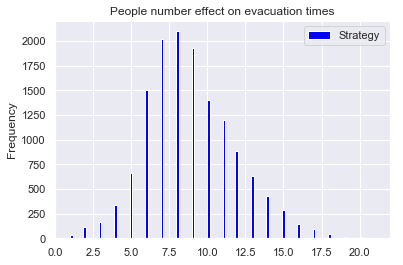

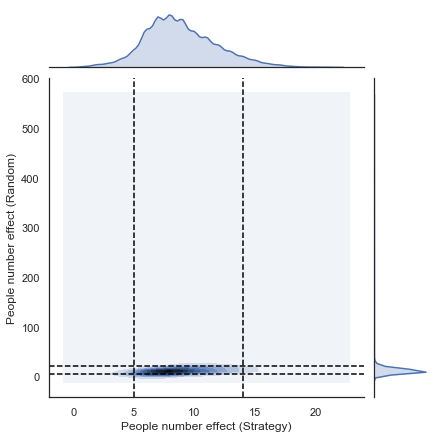

In [23]:
#Histogrm of the expriment times with
#their frequencies 


print ("95% CI of Strategic Placement:", sts.t.interval(0.95, len(E7_time)-1,
                                                                 loc=np.mean(E7_time), scale=sts.sem(E7_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E7_time, 0.05),np.quantile(E7_time, 0.95)))
print(sts.describe(E7_time))
print("--------------------------------")
print ("95% CI of Random Placement:", sts.t.interval(0.95, len(E2_time)-1, loc=np.mean(E2_time),
                                                         scale=sts.sem(E2_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E2_time, 0.05),np.quantile(E2_time, 0.95)))
print(sts.describe(E2_time))



# #finding the 90% percentile of the data

# E7_zoomed_times=[]
# for i in E7_time:
#     if (i>=np.quantile(E7_time, 0.05)) and (i<=np.quantile(E7_time, 0.95)):
#         E7_zoomed_times.append(i)     
        


plt.hist(E7_time,bins = int(np.sqrt(len(E7_time))), color = "blue",label='Strategy')
#plt.hist(E2_time,bins = int(np.sqrt(len(E2_time))), color = "red",label='Random',alpha=0.5)
plt.title("People number effect on evacuation times")
plt.ylabel("Frequency")
plt.legend()


with sns.axes_style("white"):
    #sns.jointplot(x=E5_time, y=E6_time, kind="kde", ax=axes[0, 1]);
    fig = sns.jointplot(x=E7_time, y=E2_time, kind='kde', n_levels=10)
    fig.ax_joint.axvline(x=np.quantile(E7_time, 0.05), linestyle='--', color = 'black')
    fig.ax_joint.axvline(x=np.quantile(E7_time, 0.95), linestyle='--', color = 'black')
    fig.ax_joint.axhline(y=np.quantile(E2_time, 0.05), linestyle='--', color = 'black')
    fig.ax_joint.axhline(y=np.quantile(E2_time, 0.95), linestyle='--', color = 'black')
    fig.set_axis_labels('People number effect (Strategy)', 'People number effect (Random)')

plt.show()

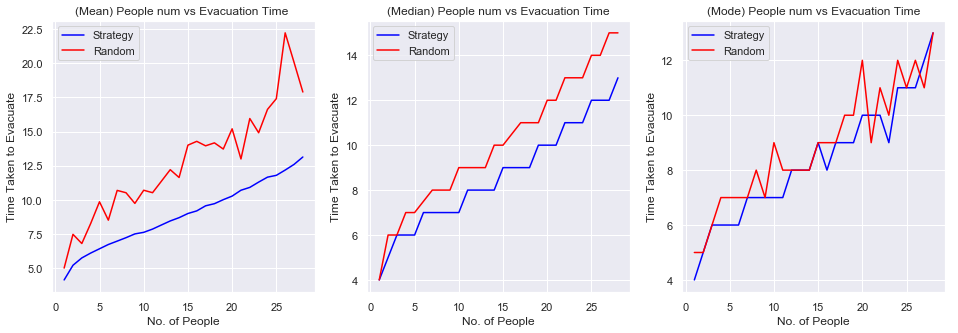

In [24]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)

plt.plot(people_num,E7_mean_time, color = "blue",label='Strategy')
plt.plot(people_num,E2_mean_time, color = "red",label='Random')

plt.title("(Mean) People num vs Evacuation Time ")
plt.xlabel("No. of People")
plt.ylabel("Time Taken to Evacuate")
plt.legend()



plt.subplot(1, 3, 2)

plt.plot(people_num,E7_median_time, color = "blue",label='Strategy')
plt.plot(people_num,E2_median_time, color = "red",label='Random')
plt.title("(Median) People num vs Evacuation Time")
plt.xlabel("No. of People")
plt.ylabel("Time Taken to Evacuate")
plt.legend()

plt.subplot(1, 3, 3)

plt.plot(people_num,E7_mode_time, color = "blue",label='Strategy')
plt.plot(people_num,E2_mode_time, color = "red",label='Random')
plt.title("(Mode) People num vs Evacuation Time")
plt.xlabel("No. of People")
plt.ylabel("Time Taken to Evacuate")
plt.legend()

#plt.show

In [25]:
"""
Experiment-7

Room Size vs Evacuation Time 

A simulation experiment of different Room
dimensions on Evacuation time
The Room h and w are varied from 8 to 22
with the rest of fixed default parameters 

"""
room_size= [*range(8,22)]
trails=1000

E8_steps = []
E8_median_time=[]
E8_mode_time=[]
E8_mean_time=[]

for num in room_size:
    counts=[]
    for i in range(trails):
        sim =crowd_egress(room_h=num, room_w=num, exit_random=False)
        sim.initialize()
        while np.count_nonzero(sim.current_state) != 0:
            sim.update()
        counts.append(sim.time)    
        E8_steps.append([num,sim.time])
        
    E8_median_time.append(np.median(counts))
    E8_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E8_mode_time.append(max(set(counts), key=counts.count))

#E8_input = [_[0] for _ in E8_steps]
E8_time = [_[1] for _ in E8_steps]

95% CI of Strategic Placement: (13.942147754032137, 14.038137960253577)
05th-95th percentiles of the data: (9.0, 19.0)
DescribeResult(nobs=14000, minmax=(6, 28), mean=13.990142857142857, variance=8.393645239966121, skewness=0.26926840092858934, kurtosis=-0.01860205887575983)
--------------------------------
95% CI of Random Placement: (26.237506012189062, 29.52120827352522)
05th-95th percentiles of the data: (10.0, 28.0)
DescribeResult(nobs=14000, minmax=(6, 2773), mean=27.879357142857142, variance=9822.551270391761, skewness=11.976010573397875, kurtosis=176.1314612707289)


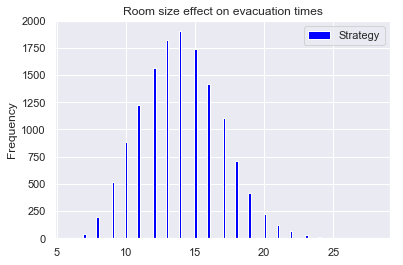

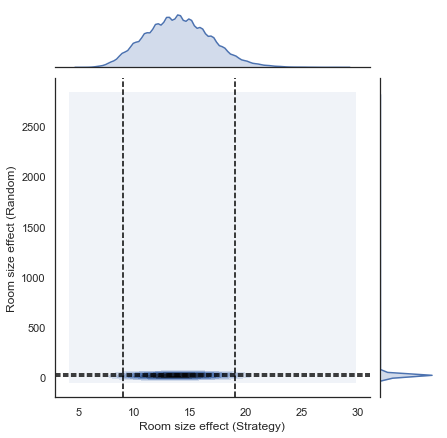

In [26]:
#Histogrm of the expriment times with
#their frequencies 


print ("95% CI of Strategic Placement:", sts.t.interval(0.95, len(E8_time)-1,
                                                                 loc=np.mean(E8_time), scale=sts.sem(E8_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E8_time, 0.05),np.quantile(E8_time, 0.95)))
print(sts.describe(E8_time))
print("--------------------------------")
print ("95% CI of Random Placement:", sts.t.interval(0.95, len(E4_time)-1, loc=np.mean(E4_time),
                                                         scale=sts.sem(E4_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E4_time, 0.05),np.quantile(E4_time, 0.95)))
print(sts.describe(E4_time))



# #finding the 90% percentile of the data

# E8_zoomed_times=[]
# for i in E8_time:
#     if (i>=np.quantile(E8_time, 0.05)) and (i<=np.quantile(E8_time, 0.95)):
#         E8_zoomed_times.append(i)           
        
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)

plt.hist(E8_time,bins = int(np.sqrt(len(E8_time))), color = "blue",label='Strategy')
#plt.hist(E4_time,bins = int(np.sqrt(len(E4_time))), color = "red",label='Random',alpha=0.5)
plt.title("Room size effect on evacuation times")
plt.ylabel("Frequency")
plt.legend()


with sns.axes_style("white"):
    fig = sns.jointplot(x=E8_time, y=E4_time, kind='kde', n_levels=10)
    fig.ax_joint.axvline(x=np.quantile(E8_time, 0.05), linestyle='--', color = 'black')
    fig.ax_joint.axvline(x=np.quantile(E8_time, 0.95), linestyle='--', color = 'black')
    fig.ax_joint.axhline(y=np.quantile(E4_time, 0.05), linestyle='--', color = 'black')
    fig.ax_joint.axhline(y=np.quantile(E4_time, 0.95), linestyle='--', color = 'black')
    fig.set_axis_labels('Room size effect (Strategy)', 'Room size effect (Random)')
plt.show()

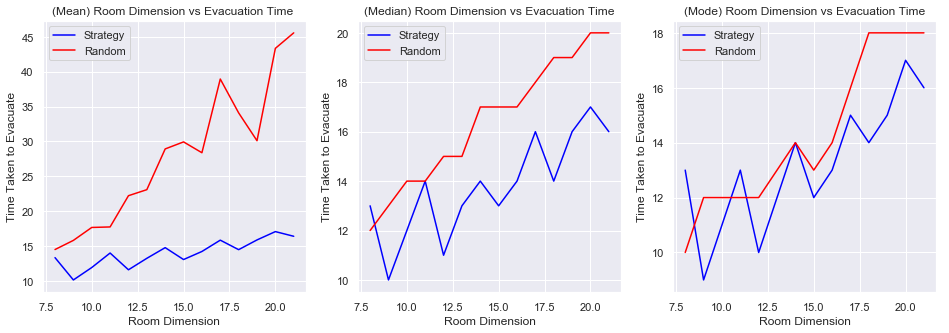

In [27]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)

plt.plot(room_size,E8_mean_time, color = "blue",label='Strategy')
plt.plot(room_size,E4_mean_time, color = "red",label='Random')

plt.title("(Mean) Room Dimension vs Evacuation Time ")
plt.xlabel("Room Dimension")
plt.ylabel("Time Taken to Evacuate")
plt.legend()



plt.subplot(1, 3, 2)

plt.plot(room_size,E8_median_time, color = "blue",label='Strategy')
plt.plot(room_size,E4_median_time, color = "red",label='Random')
plt.title("(Median) Room Dimension vs Evacuation Time")
plt.xlabel("Room Dimension")
plt.ylabel("Time Taken to Evacuate")
plt.legend()

plt.subplot(1, 3, 3)

plt.plot(room_size,E8_mode_time, color = "blue",label='Strategy')
plt.plot(room_size,E4_mode_time, color = "red",label='Random')
plt.title("(Mode) Room Dimension vs Evacuation Time")
plt.xlabel("Room Dimension")
plt.ylabel("Time Taken to Evacuate")
plt.legend()

#plt.show

**Section-3 Model Extension**

In [28]:
"""
Experiment-8

Having Wall vs Not Having Wall  
on the evacuation time

The number of people are varied from 1 to 28 
with the fixed default parameters 

Each step is counted as one interval in this scenario. 

"""


people_num= [*range(1,29)]
trails=500


E9_steps = []
E9_median_time=[]
E9_mode_time=[]
E9_mean_time=[]

for num in people_num:
    
    #vertical wall
    counts=[]
    for i in range(trails):
        sim =crowd_egress(people_num=num,wall_size=5,wall_direction='v')
        sim.initialize()
        while (np.count_nonzero(sim.current_state)-sim.wall_size) != 0:
            sim.update()
        counts.append(sim.time)    
        E9_steps.append([num,sim.time])
        
    E9_median_time.append(np.median(counts))
    E9_mean_time.append(np.mean(counts))
    #calculating the mode of hist by finding 
    #the max number of counts in the list
    E9_mode_time.append(max(set(counts), key=counts.count))
E9_time = [_[1] for _ in E9_steps]

95% CI Vertical Wall: (13.010429297879787, 13.640856416405926)
05th-95th percentiles of the data: (5.0, 21.0)
DescribeResult(nobs=14000, minmax=(1, 457), mean=13.325642857142856, variance=362.0483173236864, skewness=12.022603451154671, kurtosis=174.81909355206852)


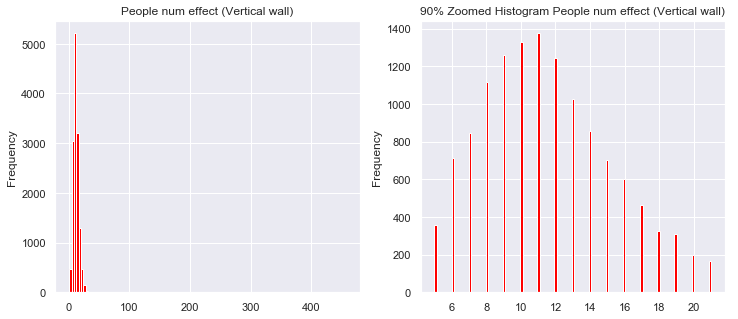

In [29]:
E9_time = [_[1] for _ in E9_steps]
#Histogrm of the expriment times with
#their frequencies 

print ("95% CI Vertical Wall:", sts.t.interval(0.95, len(E9_time)-1, loc=np.mean(E9_time), scale=sts.sem(E9_time)))
print ("05th-95th percentiles of the data:", (np.quantile(E9_time, 0.05),np.quantile(E9_time, 0.95)))
print(sts.describe(E9_time))


#finding the 90% percentile of the data
E9_zoomed_times=[]
for i in E9_time:
    if (i>=np.quantile(E9_time, 0.05)) and (i<=np.quantile(E9_time, 0.95)):
        E9_zoomed_times.append(i)     
        
        
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.hist(E9_time,bins = int(np.sqrt(len(E9_time))), color = "red")
plt.title("People num effect (Vertical wall)")
plt.ylabel("Frequency")


plt.subplot(1, 2, 2)

plt.hist(E9_zoomed_times,bins = int(np.sqrt(len(E9_zoomed_times))), color = "red")
plt.title("90% Zoomed Histogram People num effect (Vertical wall)")
plt.ylabel("Frequency")

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

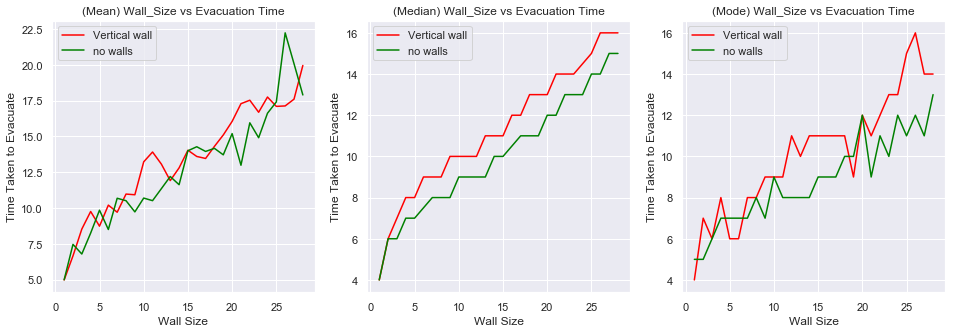

In [30]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)

plt.plot(people_num,E9_mean_time, color = "red",label='Vertical wall')
plt.plot(people_num,E2_mean_time, color = "green",label='no walls')

plt.title("(Mean) Wall_Size vs Evacuation Time")
plt.xlabel("Wall Size")
plt.ylabel("Time Taken to Evacuate")
plt.legend()



plt.subplot(1, 3, 2)

plt.plot(people_num,E9_median_time, color = "red",label='Vertical wall')
plt.plot(people_num,E2_median_time, color = "green",label='no walls')
plt.title("(Median) Wall_Size vs Evacuation Time")
plt.xlabel("Wall Size")
plt.ylabel("Time Taken to Evacuate")
plt.legend()

plt.subplot(1, 3, 3)

plt.plot(people_num,E9_mode_time, color = "red",label='Vertical wall')
plt.plot(people_num,E2_mode_time, color = "green",label='no walls')
plt.title("(Mode) Wall_Size vs Evacuation Time")
plt.xlabel("Wall Size")
plt.ylabel("Time Taken to Evacuate")
plt.legend()

plt.show